Question 1

part a) cleaning the text

In [ ]:
import re
import numpy as np
from collections import Counter

def create_training_data_optimized(input_file, vocab_size, window_size, num_negatives):
    
    with open(input_file, "r") as f:
        text = f.read(vocab_size * 20).lower()  
    
    # Clean text and split into words
    text = re.sub(r'[^a-z ]+', ' ', text)
    all_words = text.split()
 
    training_words = all_words[:vocab_size]
    
    # Create vocabulary
    unique_words = list(set(training_words))
    word_to_idx = {word: idx for idx, word in enumerate(unique_words)}
    idx_to_word = {idx: word for idx, word in enumerate(unique_words)}
    
    # Count word frequencies for negative sampling
    word_counts = Counter(training_words)
    
    # Convert words to indices
    word_indices = np.array([word_to_idx.get(word, 0) for word in training_words])
    
    # Pre-compute negative sampling distribution
    freq = np.zeros(len(word_to_idx))
    for idx in range(len(word_to_idx)):
        freq[idx] = word_counts.get(idx_to_word[idx], 0)
    
    freq = np.power(freq, 0.75)  
    freq = freq / np.sum(freq) 
    
    # Generate training data 
    training_data = []
    for i in range(len(word_indices)):
        target = word_indices[i]
        start = max(0, i - window_size)
        end = min(len(word_indices), i + window_size + 1)
        
    
        for j in range(start, end):
            if i != j:  
                context = word_indices[j]
                
               
                negatives = np.random.choice(len(word_to_idx), size = num_negatives+10, p = freq, replace = False)
                
                # Filter out target and context
                negatives = negatives[negatives != target]
                negatives = negatives[negatives != context]
                negatives = negatives[:num_negatives] 
                
                if len(negatives) == num_negatives:
                    training_data.append((np.array([target]), np.array([context]), negatives))
                
    
    return training_data, word_to_idx, idx_to_word, word_counts

input_file = "text8"
training_data, word_to_idx, idx_to_word, word_counts = create_training_data_optimized(
    input_file, 
    vocab_size=300000, 
    window_size=5, 
    num_negatives=100
)

part b) Implement the skip-gram model from scratch with negative sampling loss.

and

part c) Train your model on the text8 dataset with appropriate hyperparameters.

In [ ]:
import numpy as np

def log_sigmoid(x):
    return -np.logaddexp(0, -x)

def log_neg_sigmoid(x):
    return -np.logaddexp(0, x)

def sigmoid(x):
    return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

def forward(target_emb, context_emb, negative_embs):
    pos_score = np.sum(target_emb * context_emb, axis=1, keepdims=True)
    pos_loss = -log_sigmoid(pos_score)
    
    neg_scores = np.sum(target_emb[:, None, :] * negative_embs, axis=2)
    neg_loss = -log_neg_sigmoid(neg_scores).sum(axis=1, keepdims=True)
    
    loss = pos_loss + neg_loss
    return loss.mean(), pos_score, neg_scores

def backward(target_emb, context_emb, negative_embs, pos_score, neg_scores, lr):
    pos_grad = np.clip(sigmoid(pos_score) - 1, -5, 0)
    neg_grad = np.clip(sigmoid(neg_scores), 0, 5)
    
    target_update = lr * (pos_grad * context_emb + np.sum(neg_grad[..., None] * negative_embs, axis=1))
    context_update = lr * pos_grad * target_emb
    neg_update = lr * neg_grad[..., None] * target_emb[:, None, :]
    
    return target_update, context_update, neg_update

def train_skipgram(data_loader, vocab_size, embedding_dim, epochs, lr, batch_size=512):
    target_embeddings = np.random.uniform(-1, 1, (vocab_size, embedding_dim)) / np.sqrt(embedding_dim)
    context_embeddings = np.random.uniform(-1, 1, (vocab_size, embedding_dim)) / np.sqrt(embedding_dim)
    
    for epoch in range(epochs):
        total_loss = 0.0
        np.random.shuffle(data_loader)
        
        for i in range(0, len(data_loader), batch_size):
            batch = data_loader[i : i + batch_size]
            targets, contexts, negatives = zip(*batch)
            
            targets = np.array(targets).reshape(-1)
            contexts = np.array(contexts).reshape(-1)
            negatives = np.array(negatives)
            
            t_emb = target_embeddings[targets]
            c_emb = context_embeddings[contexts]
            n_embs = context_embeddings[negatives]
            
            loss, pos_score, neg_scores = forward(t_emb, c_emb, n_embs)
            
            t_update, c_update, n_update = backward(t_emb, c_emb, n_embs, pos_score, neg_scores, lr)
            
            target_embeddings[targets] -= t_update
            context_embeddings[contexts] -= c_update
            context_embeddings[negatives] -= n_update
            
            total_loss += loss
        
        avg_loss = total_loss / (len(data_loader) / batch_size)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    
    return target_embeddings, context_embeddings

embedding_dim = 100
epochs = 30
lr = 0.01
vocab_size = 300000
batch_size = 512

target_emb, context_emb = train_skipgram(training_data, vocab_size, embedding_dim, epochs, lr, batch_size)

Epoch 1, Loss: 2.2842
Epoch 2, Loss: 1.9645
Epoch 3, Loss: 1.9272
Epoch 4, Loss: 1.9027
Epoch 5, Loss: 1.8865
Epoch 6, Loss: 1.8716
Epoch 7, Loss: 1.8658
Epoch 8, Loss: 1.8618
Epoch 9, Loss: 1.8569
Epoch 10, Loss: 1.8549
Epoch 11, Loss: 1.8516
Epoch 12, Loss: 1.8495
Epoch 13, Loss: 1.8482
Epoch 14, Loss: 1.8500
Epoch 15, Loss: 1.8491
Epoch 16, Loss: 1.8478
Epoch 17, Loss: 1.8505
Epoch 18, Loss: 1.8488
Epoch 19, Loss: 1.8514
Epoch 20, Loss: 1.8491
Epoch 21, Loss: 1.8507
Epoch 22, Loss: 1.8505
Epoch 23, Loss: 1.8523
Epoch 24, Loss: 1.8508
Epoch 25, Loss: 1.8514
Epoch 26, Loss: 1.8526
Epoch 27, Loss: 1.8537
Epoch 28, Loss: 1.8533
Epoch 29, Loss: 1.8546
Epoch 30, Loss: 1.8549


I experimented with the various params 

i) first I took 
    embedding_dim = 100
    epochs = 5
    lr = 0.0025
    vocab_size = 10000 
    window_size=2, 
    num_negatives=10 but got loss high and also my similarity for the queen is very less 

ii) embedding_dim = 100
    epochs = 15
    lr = 0.01
    vocab_size = 100000 
    window_size=2, 
    num_negatives=10 but got loss less than previous case and also my similarity for the queen is better
    
iii)embedding_dim = 100
    epochs = 30
    lr = 0.01
    vocab_size = 300000 
    window_size=5, 
    num_negatives=100 I increased number of negative samples and also vocab size it is taking lot of time but giving better loss and also better similarity for the queen

part d) 
Visualization using SVD to project the embeddings to 2D space.

Word similarity analysis for semantically related words (e.g., “king” - “man” + “woman”
≈ “queen”).

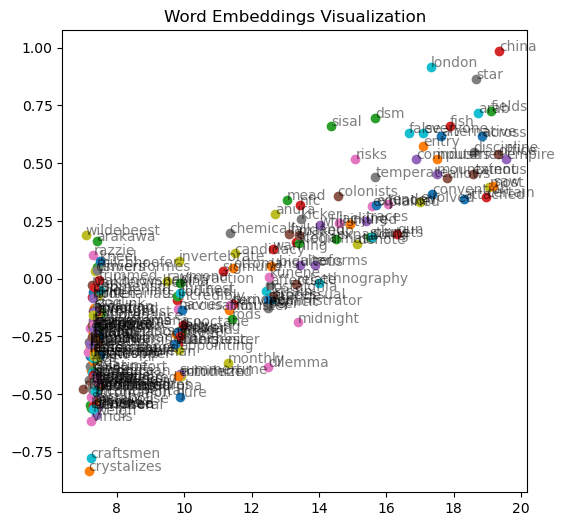

In [19]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_word_embeddings(embeddings, word_to_idx, idx_to_word, num_words):
    
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    
    words_to_plot = [word for word, _ in Counter(word_to_idx.keys()).most_common(num_words)]
    
    plt.figure(figsize=(6, 6))
    for word in words_to_plot:
        idx = word_to_idx[word]
        x, y = reduced_embeddings[idx]
        plt.scatter(x, y)
        plt.annotate(word, (x, y), alpha=0.5)
    
    plt.title("Word Embeddings Visualization")
    plt.show()


plot_word_embeddings(target_emb, word_to_idx, idx_to_word, num_words=200)

In [21]:

def find_word_analogy(embeddings, word_to_idx, idx_to_word, word1, word2, word3, top_k=1):
    if all(w in word_to_idx for w in [word1, word2, word3]):
        vec1 = embeddings[word_to_idx[word1]]
        vec2 = embeddings[word_to_idx[word2]]
        vec3 = embeddings[word_to_idx[word3]]
        analogy = vec1 - vec2 + vec3
        
        analogy /= (np.linalg.norm(analogy))
        embeddings_norm = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True))

        sims = np.dot(embeddings_norm, analogy)
        
        valid_mask = np.array([i in idx_to_word for i in range(len(sims))])
        
        excluded = [word_to_idx[word1], word_to_idx[word2], word_to_idx[word3]]
        
        masked_sims = np.where(valid_mask, sims, -np.inf)

        top_indices = np.argsort(masked_sims)[-top_k:][::-1]
        
        print(f"{word1} - {word2} + {word3} = ?")
        
        for idx in top_indices:
            if idx in idx_to_word:  
                print(f"{idx_to_word[idx]}: {sims[idx]:.4f}")
            else:
                print(f"Index {idx} not in vocabulary")
        
        
        if 'queen' in word_to_idx:
            queen_idx = word_to_idx['queen']
            if queen_idx < len(sims):
                print(f"\nQueen similarity: {sims[queen_idx]:.4f}")
                # rank = len(sims) - np.where(np.argsort(sims) == queen_idx)[0][0]
                # print(f"Queen's position: {rank}/{len(sims)}")
            else:
                print("\nQueen index out of bounds for similarity array")
        
        if len(top_indices) > 0 and top_indices[0] in idx_to_word:
            return idx_to_word[top_indices[0]]
        else:
            print("No valid analogy found with indices in vocabulary")
            return None
    else:
        missing = [w for w in [word1, word2, word3] if w not in word_to_idx]
        print(f"Words missing from vocabulary: {missing}")
        return None
find_word_analogy(target_emb, word_to_idx, idx_to_word, "king", "man", "woman")

king - man + woman = ?
king: 0.9982

Queen similarity: 0.9966


'king'

Here in case of word similarity Queen similarity is very much near to the similarity of king which is given by the analogy above. If we train by increasing embedding size or context size or negative samples you will result in queen

part e)

Start with d=100, w=5, and k=100 for general-purpose embeddings.

Reducing d for will not learn the word properly so taking appropriate d is required

Increase k if neccessary to improve contrastive learning but takes time in training so taking appropriate d is required

Choosing num_context is also important choosing larger num_context takes time in training if small context is choosed learning the proper meaning of a word will be inefficient.